In [1]:
import os
import sys
sys.path.append('lib')
import copy
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import sem

import utils
import hyperparameter

In [2]:
#* Set default precision
torch.set_default_dtype(torch.float32)

#* Set device
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda', index=0)

In [3]:
#* Tuning index and ensemble index
TUNING_INDEX = 10
ENSEMBLE_INDEX = 8

result = {}
var1_name = 'hidden_size'
var2_name = 'num_layers'
var1_list = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
var2_list = [2, 3, 4, 5, 6]

if len(var2_list) > len(var1_list):
    var1_list, var2_list = var2_list, var1_list
    var1_name, var2_name = var2_name, var1_name
print("var1: {}\nvar2: {}".format(var1_name, var2_name))


var1: hidden_size
var2: num_layers


In [4]:
for var1 in var1_list:
    for var2 in var2_list:
        prefix = var1_name + ':' + str(var1) + '/' + var2_name + ':' + str(var2)
        print("Processing {}".format(prefix), end='\t')

        param = hyperparameter.default_parameter()
        param.set_parameter(var1_name, var1)
        param.set_parameter(var2_name, var2)
        tuner = hyperparameter.tuner(parameter=param, device=DEVICE)
        tuner.run()

        result[prefix] = copy.deepcopy(tuner.result)



Processing hidden_size:50/num_layers:2	Train finished with 175.349629 seconds, 227 epochs, 0.000388 validation loss
Processing hidden_size:50/num_layers:3	Train finished with 153.300039 seconds, 168 epochs, 0.000649 validation loss
Processing hidden_size:50/num_layers:4	Train finished with 141.076554 seconds, 134 epochs, 0.000994 validation loss
Processing hidden_size:50/num_layers:5	Train finished with 129.037959 seconds, 109 epochs, 0.001254 validation loss
Processing hidden_size:50/num_layers:6	Train finished with 238.394763 seconds, 180 epochs, 0.000953 validation loss
Processing hidden_size:100/num_layers:2	Train finished with 141.223469 seconds, 166 epochs, 0.000410 validation loss
Processing hidden_size:100/num_layers:3	Train finished with 137.669482 seconds, 135 epochs, 0.000497 validation loss
Processing hidden_size:100/num_layers:4	Train finished with 116.836834 seconds, 100 epochs, 0.000717 validation loss
Processing hidden_size:100/num_layers:5	Train finished with 165.42653

In [ ]:
result = pd.DataFrame(result).T
result.to_pickle(os.path.join("tuning", "{}.{}_{}-{}.pkl".format(TUNING_INDEX, var1_name, var2_name, ENSEMBLE_INDEX)))

# Plot the loss


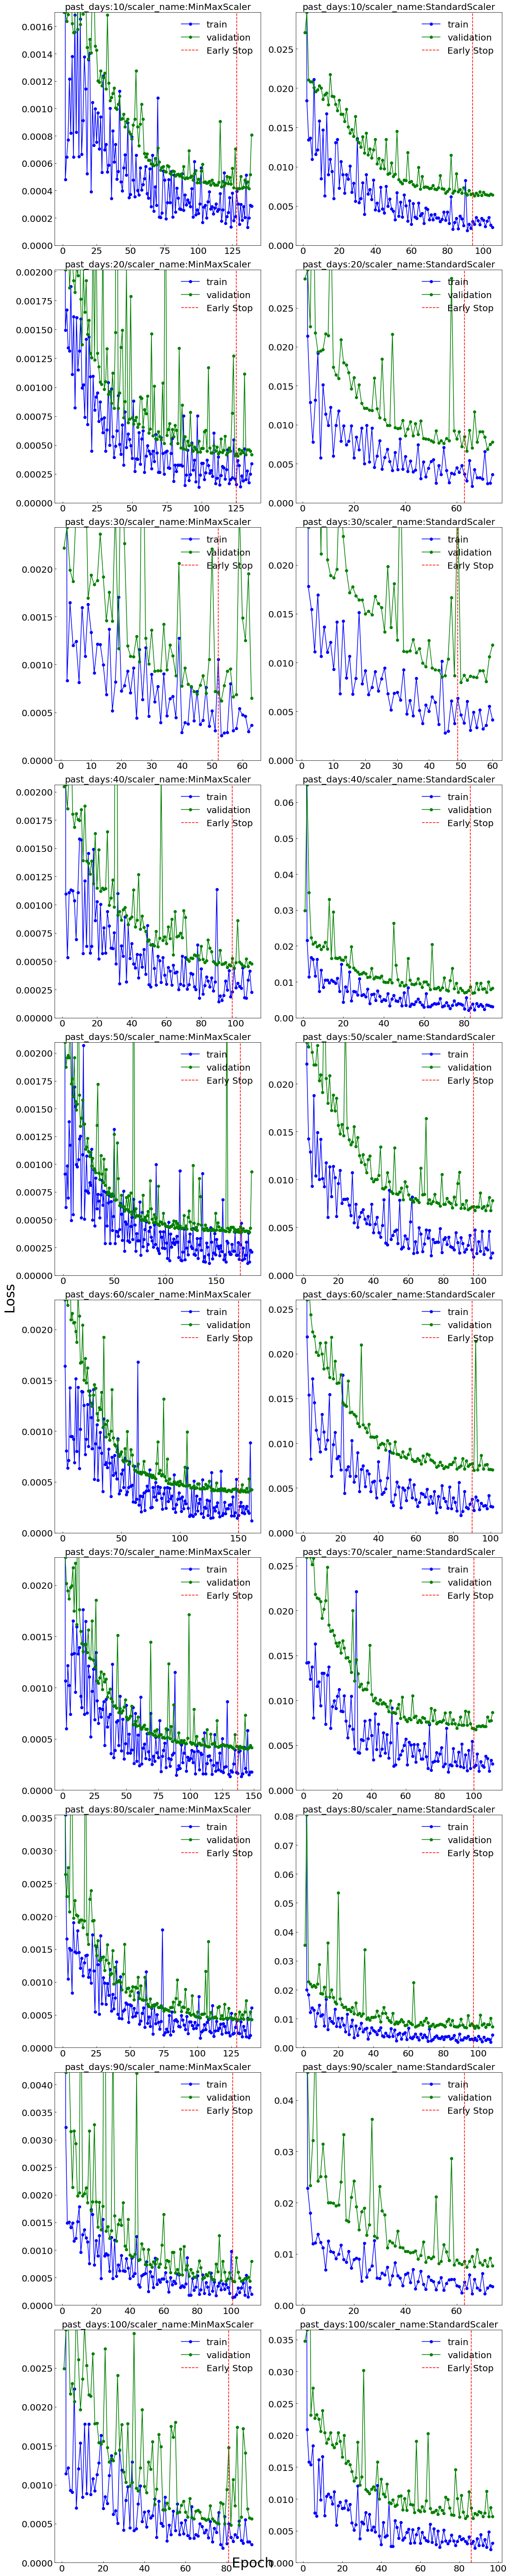

In [6]:
def plot_loss(result: pd.DataFrame, var1_list, var2_list, var1_name, var2_name):
    num_row = len(var1_list)
    num_col = len(var2_list)
    fig = plt.figure(figsize=(8 * num_col, 8 * num_row))
    index = 1
    for var1 in var1_list:
        for var2 in var2_list:
            prefix = var1_name + ":" + str(var1) + "/" + var2_name + ":" + str(var2)
            ax = plt.subplot(num_row, num_col, index)
            train_loss_list = np.array(result['train_loss_list'][prefix])
            val_loss_list = np.array(result['val_loss_list'][prefix])
            ax = utils.plot_loss(train_loss_list=train_loss_list,
                                 val_loss_list=val_loss_list,
                                 ax=ax,
                                 stop_epoch=result['epoch'][prefix])

            ax.set_title(prefix, fontsize=20)
            ax.set_xlabel('', fontsize=0)
            ax.set_ylabel('', fontsize=0)
            ax.set_ylim([0, max(train_loss_list[1], val_loss_list[1])])
            ax.legend(loc='upper right', fontsize=20, frameon=False)
            index += 1
    fig.supxlabel("Epoch", fontsize=30)
    fig.supylabel("Loss", fontsize=30)
    fig.tight_layout()
    fig.show()

plot_loss(result, var1_list=var1_list, var2_list=var2_list, var1_name=var1_name, var2_name=var2_name)



# Get statistics of ensemble result

In [4]:
MAX_ENSEMBLE = 8
avg_mse, rec_mse = {}, {}
for var1 in var1_list:
    avg_mse[var1], rec_mse[var1] = {}, {}
    for var2 in var2_list:
        avg_mse[var1][var2] = []
        rec_mse[var1][var2] = []

ensemble_result = pd.read_pickle(os.path.join("tuning", "{}.{}_{}-{}.pkl".format(TUNING_INDEX, var1_name, var2_name, 0)))
ensemble_result = ensemble_result.drop(columns=['train_loss_list', 'val_loss_list'])
for var1 in var1_list:
    for var2 in var2_list:
        prefix = var1_name + ":" + str(var1) + "/" + var2_name + ":" + str(var2)
        avg_mse[var1][var2].append(ensemble_result['avg_test_mse'][prefix])
        rec_mse[var1][var2].append(ensemble_result['recurrent_test_mse'][prefix])

for ensemble in range(1, MAX_ENSEMBLE):
    temp = pd.read_pickle(os.path.join("tuning", "{}.{}_{}-{}.pkl".format(TUNING_INDEX, var1_name, var2_name, ensemble)))
    temp = temp.drop(columns=['train_loss_list', 'val_loss_list'])
    ensemble_result += temp
    for var1 in var1_list:
        for var2 in var2_list:
            prefix = var1_name + ":" + str(var1) + "/" + var2_name + ":" + str(var2)
            avg_mse[var1][var2].append(temp['avg_test_mse'][prefix])
            rec_mse[var1][var2].append(temp['recurrent_test_mse'][prefix])

ensemble_result /= MAX_ENSEMBLE

# Test ensemble result

In [5]:
avg_mse, rec_mse = pd.DataFrame(avg_mse), pd.DataFrame(rec_mse)
avg_mse_mean = copy.deepcopy(avg_mse)
avg_mse_sem = copy.deepcopy(avg_mse)
rec_mse_mean = copy.deepcopy(rec_mse)
rec_mse_sem = copy.deepcopy(rec_mse)

for col in avg_mse.columns:
    for index in avg_mse.index:
        avg_mse_mean.at[index, col] = np.mean(avg_mse_mean.at[index, col])
        rec_mse_mean.at[index, col] = np.mean(rec_mse_mean.at[index, col])
        avg_mse_sem.at[index, col] = sem(avg_mse_sem.at[index, col])
        rec_mse_sem.at[index, col] = sem(rec_mse_sem.at[index, col])

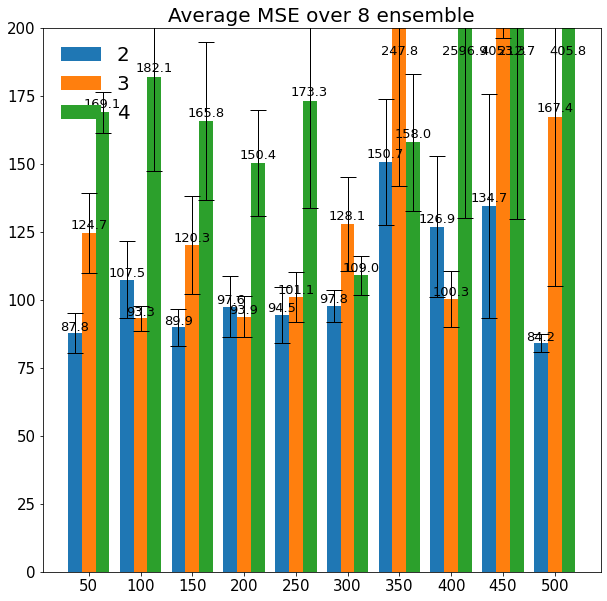

In [8]:
def plot_MSE(mse_mean, mse_sem, ylim_top=None):
    fig, ax = plt.subplots(figsize=(10, 10))
    major_label = mse_mean.columns
    minor_label = mse_mean.index

    xtick_loc = np.arange(len(major_label))
    bar_width = 1.0 / len(minor_label) * 0.8

    #* Draw bar plot with error bor
    for i, minor in enumerate(minor_label):
        ax.bar(xtick_loc + bar_width * i, height=mse_mean.loc[minor], yerr=mse_sem.loc[minor], width=bar_width, label=minor, error_kw=dict(lw=1, capsize=8))

    #* Set anotation
    for patch in ax.patches:
        left, _, width, height = patch.get_bbox().bounds
        if ylim_top is not None:
            ax.annotate('{:.1f}'.format(height), (left + width / 2, min(height * 1.01, ylim_top * 0.95)), ha='center', fontsize=13)
        else:
            ax.annotate('{:.1f}'.format(height), (left + width / 2, height * 1.01), ha='center', fontsize=13)

    ax.set_xticks(xtick_loc + bar_width * (len(minor_label) - 1) / 2)
    ax.set_xticklabels(major_label, fontsize=20)
    ax.tick_params(axis='both', labelsize=15)
    ax.legend(loc='best', frameon=False, fontsize=20)
    if ylim_top is not None:
        ax.set_ylim(top=ylim_top)
    ax.set_title("Average MSE over {} ensemble".format(MAX_ENSEMBLE), fontsize=20)

    fig.show()

plot_MSE(avg_mse_mean.loc[[2,3,4]], avg_mse_sem.loc[[2,3,4]], ylim_top=200)
# plot_MSE(avg_mse_mean, avg_mse_sem, ylim_top=200)


In [9]:
min_MSE = np.Inf
for col in avg_mse_mean.columns:
    for idx in avg_mse_mean.index:
        if min_MSE > avg_mse_mean.at[idx,col]:
            min_MSE = avg_mse_mean.at[idx,col]
            location = col, idx

print(location)
print(min_MSE)

(500, 2)
84.197016239638
